#### Experiment: 

Evaluate pruning by magnitude weighted by coactivations (more thorough evaluation), compare it to baseline (SET), in GSC. Applied only to linear layers

#### Motivation.

Check if results are consistently above baseline.

#### Conclusion


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import glob
import tabulate
import pprint
import click
import numpy as np
import pandas as pd
from ray.tune.commands import *
from nupic.research.frameworks.dynamic_sparse.common.browser import *

import matplotlib.pyplot as plt
from matplotlib import rcParams

%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette("colorblind")

## Load and check data

In [3]:
exps = ['improved_mag_gsc_eval3', 'improved_mag_gsc_eval4']
paths = [os.path.expanduser("~/nta/results/{}".format(e)) for e in exps]
df = load_many(paths)

In [4]:
df.head(5)

,Experiment Name,train_acc_max,train_acc_max_epoch,train_acc_min,train_acc_min_epoch,train_acc_median,train_acc_last,val_acc_max,val_acc_max_epoch,val_acc_min,...,model,momentum,network,on_perc,optim_alg,pruning_early_stop,test_noise,use_kwinners,weight_decay,weight_prune_perc
0,"0_model=DSNNWeightedMag,on_perc=0.0",0.092960,19,0.087052,47,0.089689,0.089542,0.103448,22,0.000000,...,DSNNWeightedMag,0,GSCHeb,0.000,SGD,2,False,True,0.01,0.3
1,"1_model=DSNNMixedHeb,on_perc=0.0",0.091934,24,0.085880,33,0.089591,0.089542,0.103448,10,0.000000,...,DSNNMixedHeb,0,GSCHeb,0.000,SGD,2,False,True,0.01,0.3
2,"2_model=SparseModel,on_perc=0.0",0.092325,38,0.085587,99,0.089322,0.085587,0.103448,5,0.000000,...,SparseModel,0,GSCHeb,0.000,SGD,2,False,True,0.01,0.3
3,"3_model=DSNNWeightedMag,on_perc=0.005",0.399522,7,0.156821,0,0.199736,0.196026,0.394592,8,0.145376,...,DSNNWeightedMag,0,GSCHeb,0.005,SGD,2,False,True,0.01,0.3
4,"4_model=DSNNMixedHeb,on_perc=0.005",0.365931,11,0.181330,0,0.296016,0.296065,0.362461,11,0.087382,...,DSNNMixedHeb,0,GSCHeb,0.005,SGD,2,False,True,0.01,0.3


In [5]:
# replace hebbian prine
df['hebbian_prune_perc'] = df['hebbian_prune_perc'].replace(np.nan, 0.0, regex=True)
df['weight_prune_perc'] = df['weight_prune_perc'].replace(np.nan, 0.0, regex=True)

In [6]:
df.columns

Index(['Experiment Name', 'train_acc_max', 'train_acc_max_epoch',
       'train_acc_min', 'train_acc_min_epoch', 'train_acc_median',
       'train_acc_last', 'val_acc_max', 'val_acc_max_epoch', 'val_acc_min',
       'val_acc_min_epoch', 'val_acc_median', 'val_acc_last', 'epochs',
       'experiment_file_name', 'trial_time', 'mean_epoch_time',
       'batch_size_test', 'batch_size_train', 'data_dir', 'dataset_name',
       'debug_sparse', 'debug_weights', 'device', 'hebbian_grow',
       'hebbian_prune_perc', 'learning_rate', 'lr_gamma', 'lr_milestones',
       'lr_scheduler', 'model', 'momentum', 'network', 'on_perc', 'optim_alg',
       'pruning_early_stop', 'test_noise', 'use_kwinners', 'weight_decay',
       'weight_prune_perc'],
      dtype='object')

In [7]:
df.shape

(112, 40)

In [8]:
df.iloc[1]

Experiment Name                          1_model=DSNNMixedHeb,on_perc=0.0
train_acc_max                                                   0.0919344
train_acc_max_epoch                                                    24
train_acc_min                                                   0.0858803
train_acc_min_epoch                                                    33
train_acc_median                                                0.0895909
train_acc_last                                                   0.089542
val_acc_max                                                      0.103448
val_acc_max_epoch                                                      10
val_acc_min                                                             0
val_acc_min_epoch                                                       0
val_acc_median                                                  0.0971787
val_acc_last                                                    0.0971787
epochs                                

In [9]:
df.groupby('model')['model'].count()

model
DSNNMixedHeb       37
DSNNWeightedMag    38
SparseModel        37
Name: model, dtype: int64

 ## Analysis

Experiment Details

In [10]:
# Did any  trials failed?
df[df["epochs"]<30]["epochs"].count()

1

In [11]:
# Removing failed or incomplete trials
df_origin = df.copy()
df = df_origin[df_origin["epochs"]>=30]
df.shape

(111, 40)

In [12]:
# which ones failed?
# failed, or still ongoing?
df_origin['failed'] = df_origin["epochs"]<30
df_origin[df_origin['failed']]['epochs']

111    9
Name: epochs, dtype: int64

In [13]:
# helper functions
def mean_and_std(s):
    return "{:.3f} ± {:.3f}".format(s.mean(), s.std())

def round_mean(s):
    return "{:.0f}".format(round(s.mean()))

stats = ['min', 'max', 'mean', 'std']

def agg(columns, filter=None, round=3):
    if filter is None:
        return (df.groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)
    else:
        return (df[filter].groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)


##### Does improved weight pruning outperforms regular SET

In [14]:
agg(['model'])

val_acc_max_epoch val_acc_max                      model
                       round_mean         min    max   mean    std count
model                                                                   
DSNNMixedHeb                   47       0.103  0.951  0.824  0.223    37
DSNNWeightedMag                55       0.103  0.952  0.836  0.219    37
SparseModel                    73       0.103  0.948  0.807  0.236    37

In [15]:
agg(['on_perc'])

val_acc_max_epoch val_acc_max                      model
               round_mean         min    max   mean    std count
on_perc                                                         
0.000                  10       0.103  0.106  0.104  0.001     6
0.005                  27       0.218  0.416  0.348  0.075     6
0.010                  38       0.609  0.732  0.663  0.052     6
0.015                  39       0.761  0.808  0.785  0.020     6
0.020                  50       0.811  0.852  0.834  0.017     6
0.025                  59       0.841  0.905  0.875  0.026     6
0.030                  74       0.865  0.915  0.891  0.021     6
0.035                  65       0.880  0.922  0.900  0.018     6
0.040                  73       0.895  0.926  0.912  0.012     6
0.045                  74       0.910  0.942  0.928  0.011     6
0.050                  76       0.921  0.938  0.928  0.006     6
0.055                  63       0.928  0.937  0.933  0.004     6
0.060                  73       0.933  0.935  0.934  0.001     6
0.065                  61       0.929  0.945  0.937  0.007     6
0.070                  57       0.933  0.943  0.937  0.004     6
0.075                  56       0.933  0.949  0.941  0.007     6
0.080                  90       0.938  0.948  0.943  0.005     3
0.085                  79       0.940  0.947  0.944  0.004     3
0.090                  63       0.944  0.951  0.948  0.004     3
0.095                  77       0.947  0.949  0.948  0.001     3
0.100                  69       0.946  0.952  0.948  0.003     3

In [16]:
agg(['on_perc', 'model'])

val_acc_max_epoch val_acc_max                       \
                               round_mean         min    max   mean    std   
on_perc model                                                                
0.000   DSNNMixedHeb                    6       0.103  0.103  0.103  0.000   
        DSNNWeightedMag                13       0.103  0.103  0.103  0.000   
        SparseModel                    10       0.103  0.106  0.105  0.002   
0.005   DSNNMixedHeb                   10       0.362  0.396  0.379  0.024   
        DSNNWeightedMag                 8       0.395  0.416  0.405  0.015   
        SparseModel                    62       0.218  0.303  0.261  0.060   
0.010   DSNNMixedHeb                   12       0.639  0.647  0.643  0.006   
        DSNNWeightedMag                15       0.723  0.732  0.728  0.007   
        SparseModel                    88       0.609  0.625  0.617  0.012   
0.015   DSNNMixedHeb                   15       0.786  0.789  0.787  0.002   
        DSNNWeightedMag                21       0.805  0.808  0.806  0.002   
        SparseModel                    82       0.761  0.765  0.763  0.003   
0.020   DSNNMixedHeb                   18       0.845  0.852  0.849  0.005   
        DSNNWeightedMag                48       0.830  0.846  0.838  0.012   
        SparseModel                    84       0.811  0.819  0.815  0.006   
0.025   DSNNMixedHeb                   43       0.873  0.877  0.875  0.003   
        DSNNWeightedMag                48       0.902  0.905  0.904  0.002   
        SparseModel                    86       0.841  0.850  0.845  0.006   
0.030   DSNNMixedHeb                   62       0.870  0.890  0.880  0.015   
        DSNNWeightedMag                76       0.913  0.915  0.914  0.002   
        SparseModel                    84       0.865  0.891  0.878  0.019   
0.035   DSNNMixedHeb                   64       0.894  0.903  0.899  0.006   
        DSNNWeightedMag                72       0.918  0.922  0.920  0.003   
        SparseModel                    60       0.880  0.882  0.881  0.002   
0.040   DSNNMixedHeb                   42       0.911  0.916  0.914  0.003   
        DSNNWeightedMag                83       0.922  0.926  0.924  0.003   
        SparseModel                    93       0.895  0.904  0.899  0.006   
0.045   DSNNMixedHeb                   80       0.928  0.930  0.929  0.002   
        DSNNWeightedMag                80       0.934  0.942  0.938  0.006   
        SparseModel                    62       0.910  0.921  0.916  0.008   
...                                   ...         ...    ...    ...    ...   
0.055   DSNNMixedHeb                   44       0.933  0.937  0.935  0.003   
        DSNNWeightedMag                68       0.931  0.936  0.934  0.004   
        SparseModel                    78       0.928  0.933  0.930  0.004   
0.060   DSNNMixedHeb                   78       0.933  0.935  0.934  0.001   
        DSNNWeightedMag                64       0.933  0.935  0.934  0.002   
        SparseModel                    78       0.933  0.934  0.933  0.001   
0.065   DSNNMixedHeb                   52       0.933  0.945  0.939  0.009   
        DSNNWeightedMag                48       0.940  0.943  0.941  0.002   
        SparseModel                    82       0.929  0.931  0.930  0.001   
0.070   DSNNMixedHeb                   52       0.936  0.938  0.937  0.002   
        DSNNWeightedMag                48       0.933  0.943  0.938  0.007   
        SparseModel                    72       0.935  0.935  0.935  0.001   
0.075   DSNNMixedHeb                   50       0.933  0.949  0.941  0.011   
        DSNNWeightedMag                64       0.938  0.948  0.943  0.007   
        SparseModel                    52       0.934  0.944  0.939  0.007   
0.080   DSNNMixedHeb                   81       0.944  0.944  0.944    NaN   
        DSNNWeightedMag                99       0.948  0.948  0.948    NaN   
        SparseModel                    89     

In [17]:
# translate model names
rcParams['figure.figsize'] = 16, 8
d = {
    'DSNNWeightedMag': 'DSNN',
    'DSNNMixedHeb': 'SET',
    'SparseModel': 'Static',        
}
df_plot = df.copy()
df_plot['model'] = df_plot['model'].apply(lambda x: d[x])

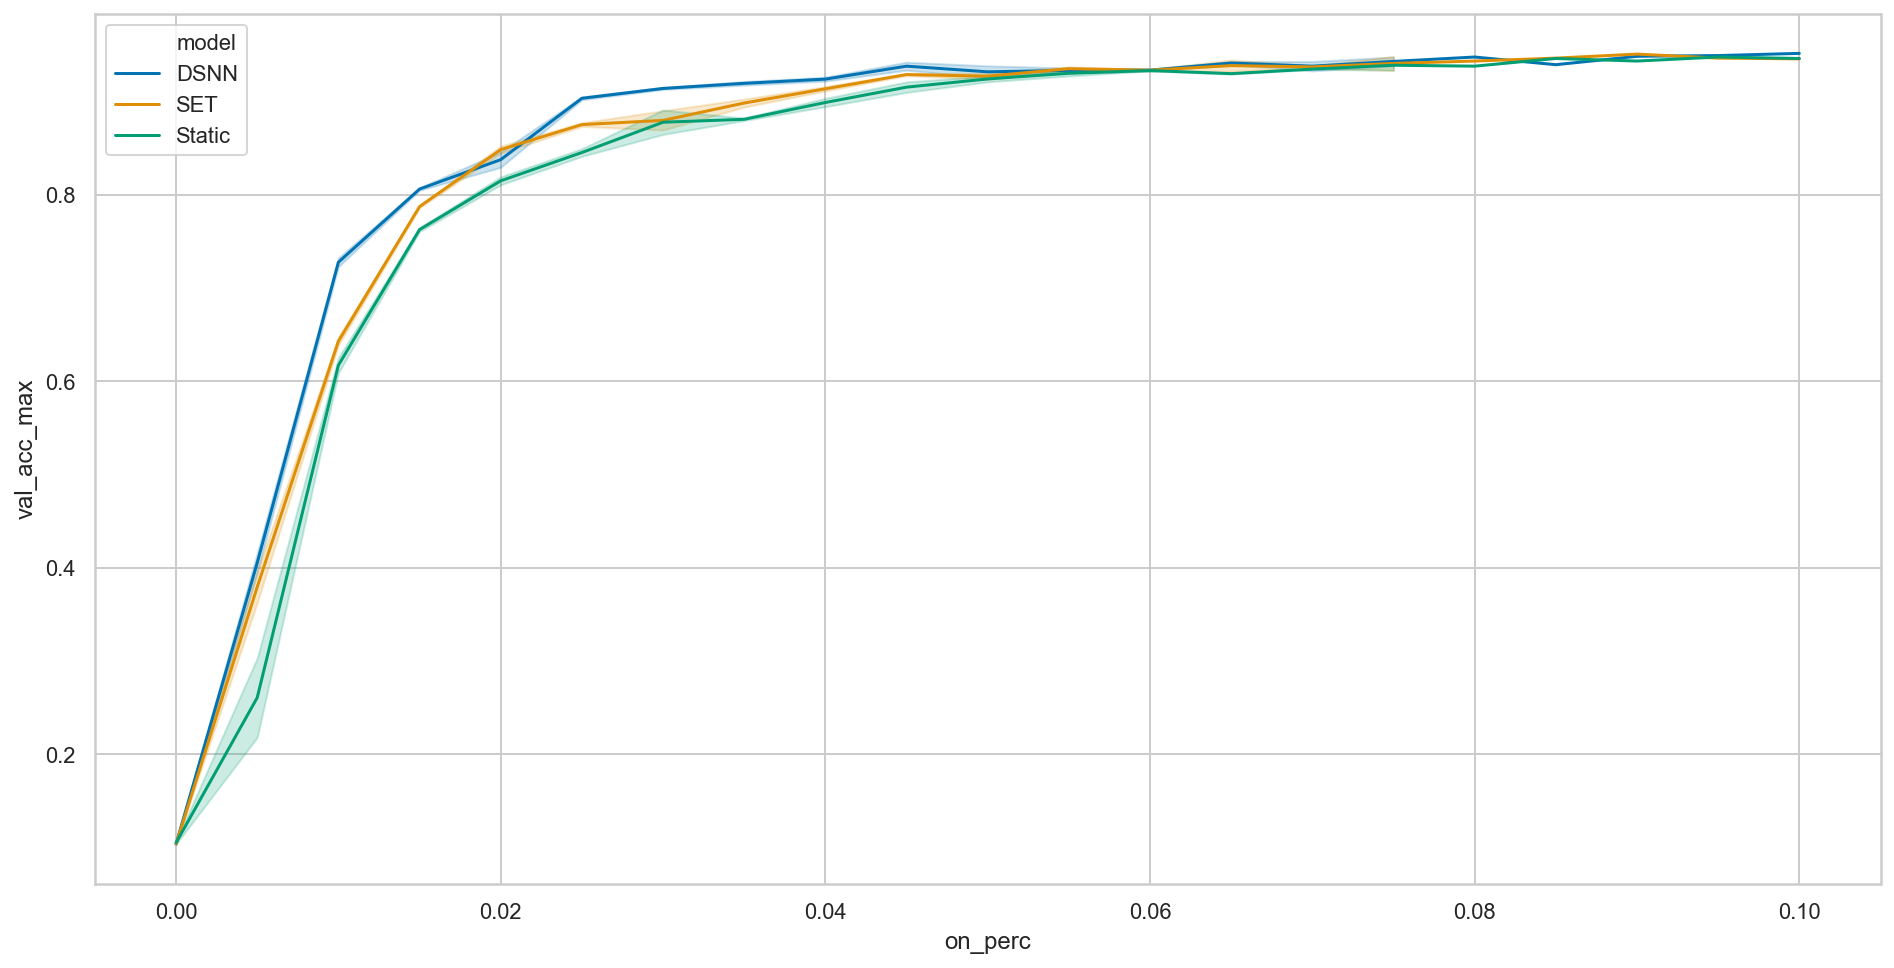

In [21]:
# sns.scatterplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')
sns.lineplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')

(0.8, 0.98)

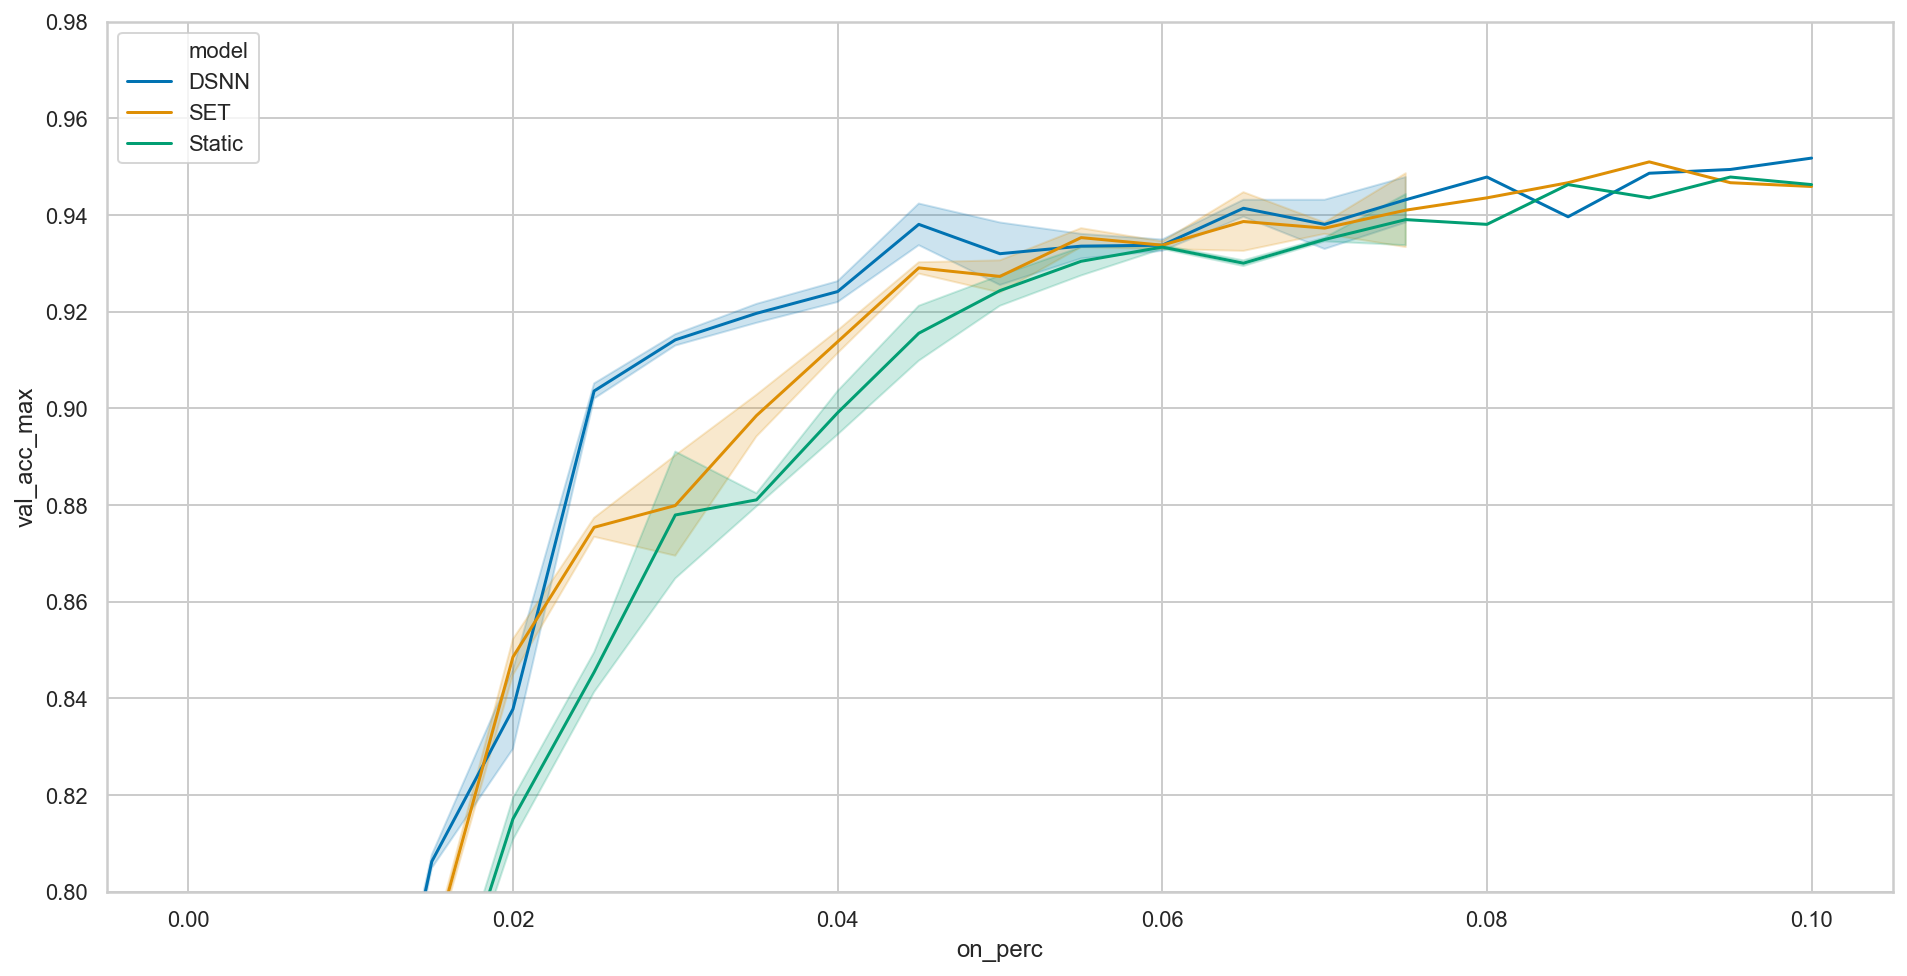

In [18]:
# sns.scatterplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')
sns.lineplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')
plt.ylim(0.8,0.98)

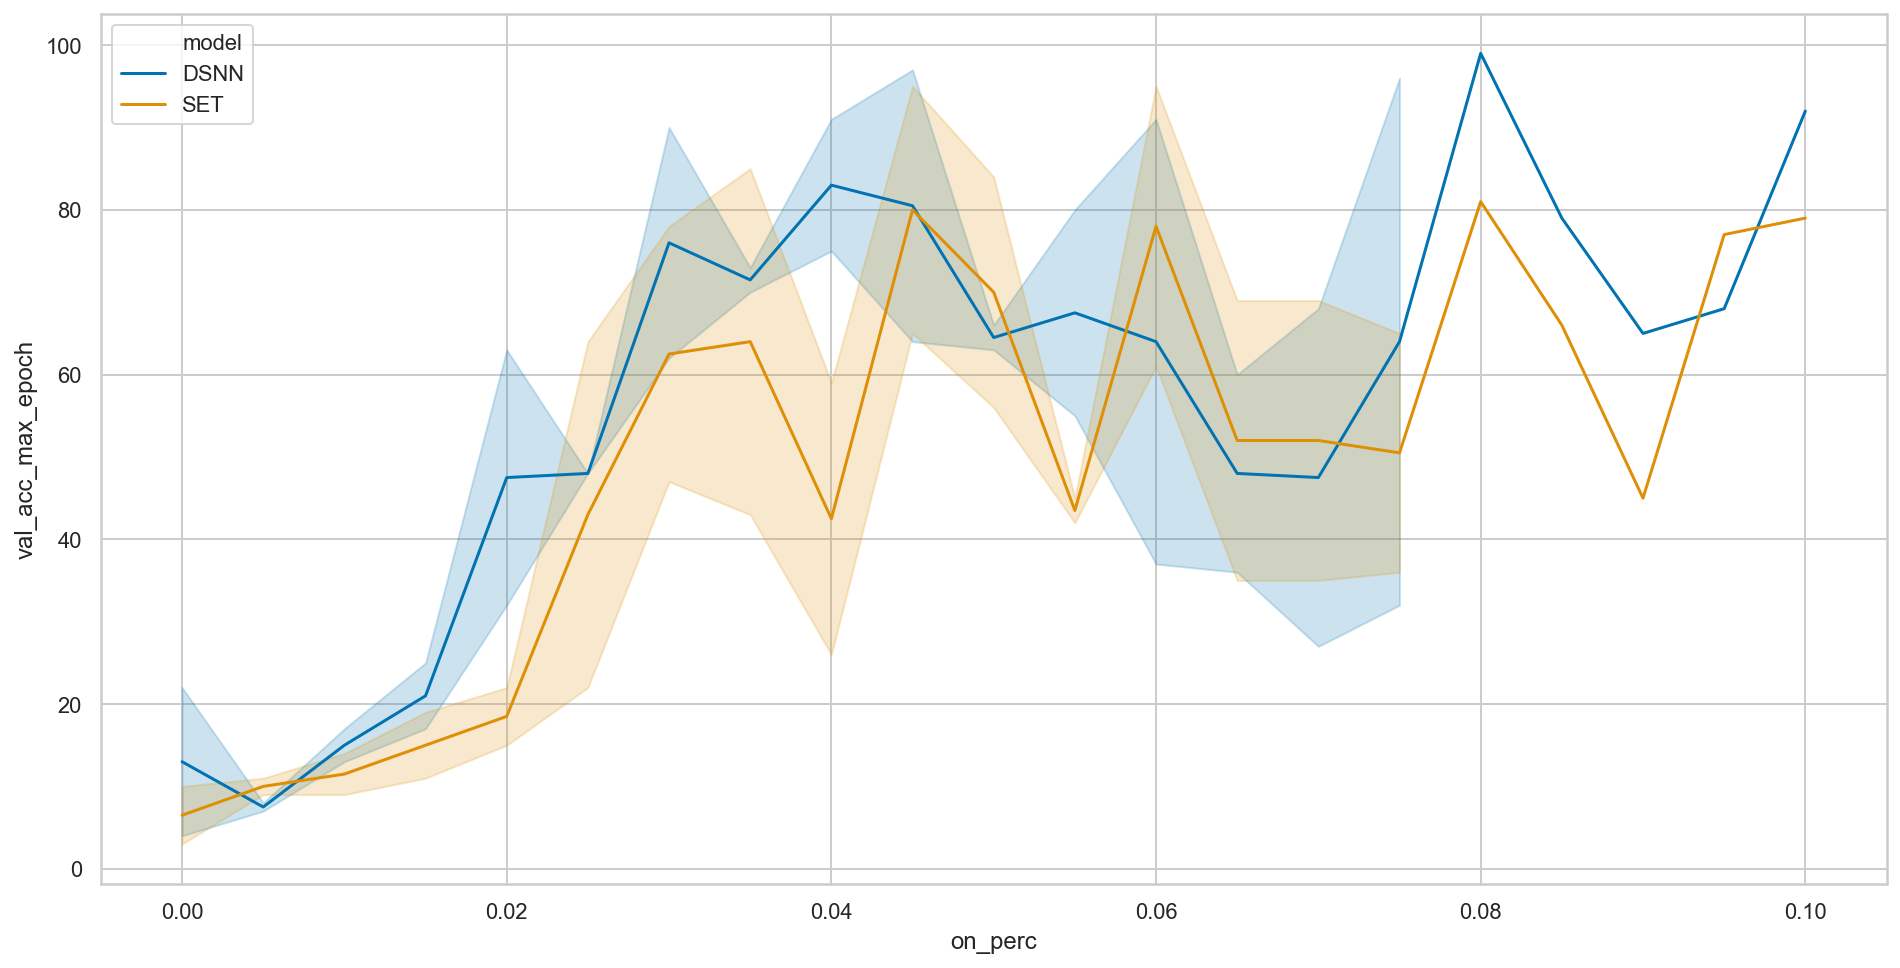

In [19]:
rcParams['figure.figsize'] = 16, 8
filter = df_plot['model'] != 'Static'
sns.lineplot(data=df_plot[filter], x='on_perc', y='val_acc_max_epoch', hue='model')

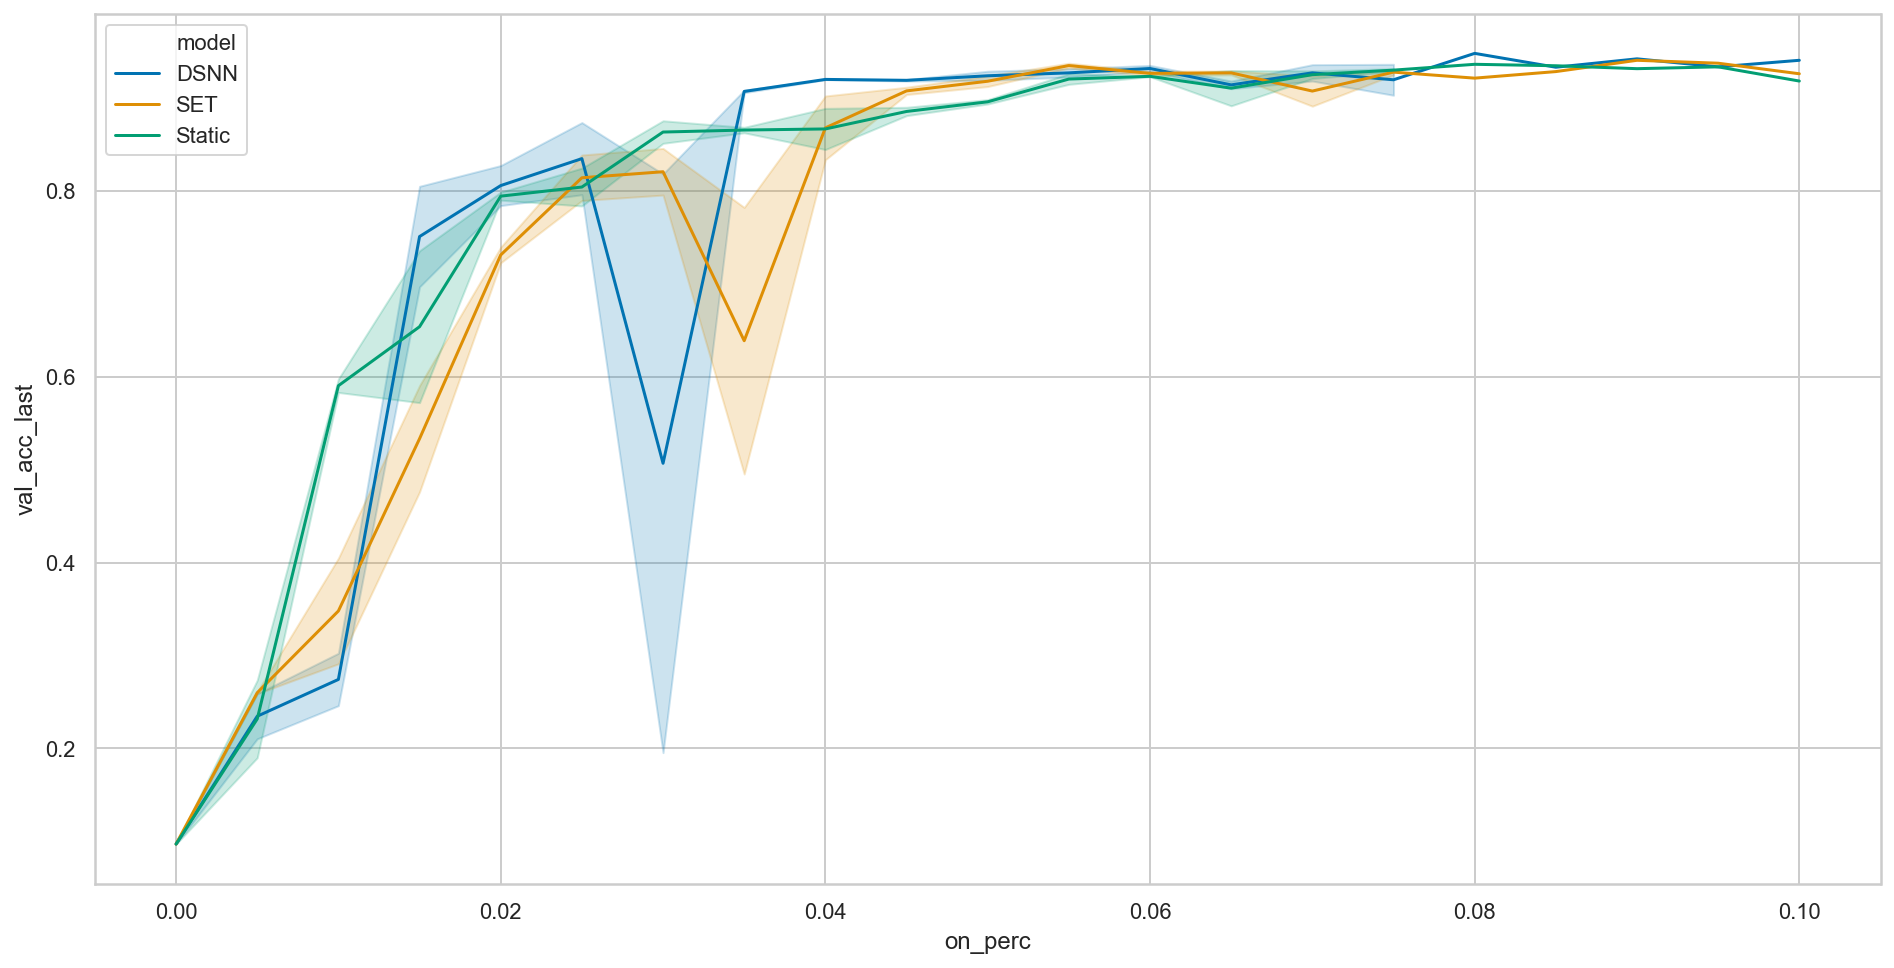

In [20]:
sns.lineplot(data=df_plot, x='on_perc', y='val_acc_last', hue='model')